# Spectrally Normalized GAN (SN-GAN)

In this notebook, we'll implement **spectral normalization**, a weight normalization technique to stabilize the training of the discriminator, as proposed in [Spectral Normalization for Generative Adversarial Networks paper in 2018](https://arxiv.org/abs/1802.05957).

SN-GAN normalizes the weight matrices in the discriminator by their corresponding [spectral norm](https://calculus.subwiki.org/wiki/Spectral_norm#:~:text=The%20spectral%20norm%20of%20a,where%20denotes%20the%20Euclidean%20norm.), which helps control the Lipschitz constant of the discriminator. As we hve saw with WGAN, is important in ensuring the boundedness of the optimal discriminator. In the WGAN case, this makes it so that the underlying W-loss function for the discriminator (or more precisely, the critic) is valid. As a result, spectral normalization helps improve stability and avoid vanishing gradient problems and mode collapse.

## Spectral Norm (SPN)

SPN of a matrix $W$ is typically represented as $\sigma(W)$. It's the matrix's largest singular value, which can be obtained via singular value decomposition (SVD).

SVD is a generalization of [eigendecomposition](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix) and is used to factorize a matrix as $W = U\Sigma V^\top$, where $U, V$ are orthogonal matrices and $\Sigma$ is a matrix of singular values on its diagonal. Note that $\Sigma$ doesn't have to be square.

\begin{align*}
    \Sigma = \begin{bmatrix}\sigma_1 & & \\ & \sigma_2 \\ & & \ddots \\ & & & \sigma_n\end{bmatrix}
\end{align*}

where $\sigma_1$ and $\sigma_n$ are the largest and smallest singular values, respectively. Intuitively, larger values correspond to larger amounts of stretching a matrix can apply to another vector. Following this notation, $\sigma(W) = \sigma_1$.

**Applying SVD to Spectral Normalization**

To spectrally normalize the weight matrix, you divide every value in the matrix by its spectral norm. As a result, a spectrally normalized matrix $\overline{W}_{SN}$ can be expressed as

\begin{align*}
  \overline{W}_{SN} = \dfrac{W}{\sigma(W)},
\end{align*}

In practice, computing the SVD of $W$ is expensive, so the authors of the SN-GAN paper do something very neat. They instead approximate the left and right singular vectors, $\tilde{u}$ and $\tilde{v}$ respectively, through power iteration such that $\sigma(W) \approx \tilde{u}^\top W\tilde{v}$.

Starting from randomly initialization, $\tilde{u}$ and $\tilde{v}$ are updated according to

\begin{align*}
  \tilde{u} &:= \dfrac{W^\top\tilde{u}}{||W^\top\tilde{u}||_2} \\
  \tilde{v} &:= \dfrac{W\tilde{v}}{||W\tilde{v}||_2}
\end{align*}

In practice, one round of iteration is sufficient to "achieve satisfactory performance" as per the authors.

Don't worry if you don't completely follow this! The algorithm is conveniently implemented as `torch.nn.utils.spectral_norm` in PyTorch, so as long as you get the general gist of how it might be useful and when to use it, then you're all set.


## DCGAN with Spectral Normalization

We will walk through how to apply spectral normalization to DCGAN as an example, using our earlier DCGAN implementation. You can always add spectral normalization to your other models too.


In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

### DCGAN Generator

Since spectral normalization is only applied to the matrices in the discriminator, the generator implementation is the same as the original.

In [ ]:
class Generator(nn.Module):
   def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),)
   def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
    if not final_layer:
      return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),)
    else:
      return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )
   def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.z_dim, 1, 1)

   def forward(self, noise):
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

In [ ]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

### DCGAN Discriminator

For the discriminator, you can wrap each `nn.Conv2d` with `nn.utils.spectral_norm`. In the backend, this introduces parameters for $\tilde{u}$ and $\tilde{v}$ in addition to $W$ so that the $W_{SN}$ can be computed as $\tilde{u}^\top W\tilde{v}$ in runtime.

Pytorch also provides a `nn.utils.remove_spectral_norm` function, which collapses the 3 separate parameters into a single explicit $\overline{W}_{SN} := \tilde{u}^\top W\tilde{v}$. You should only apply this to your convolutional layers during inference to improve runtime speed.

It is important note that spectral norm does not eliminate the need for batch norm. Spectral norm affects the weights of each layer, while batch norm affects the activations of each layer. You can see both in a discriminator architecture, but you can also see just one of them. Hope this is something you have fun experimenting with!

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):

        if not final_layer:
            return nn.Sequential(
                nn.utils.spectral_norm(nn.Conv2d(input_channels, output_channels, kernel_size, stride)),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.utils.spectral_norm(nn.Conv2d(input_channels, output_channels, kernel_size, stride)),
            )

    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

### Training SN-DCGAN

You can now put everything together and train a spectrally normalized DCGAN! Here are all your parameters for initialization and optimization.

In [ ]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 50
z_dim = 64
display_step = 5_000
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002

# These parameters control the optimizer's momentum, which you can read more about here:
# https://distill.pub/2017/momentum/ but you don’t need to worry about it for this course
beta_1 = 0.5
beta_2 = 0.999
device = 'cuda'

# We tranform our image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST(".", download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:11<00:00, 900kB/s] 


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 65.4kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.55MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Now, initialize the generator, the discriminator, and the optimizers.

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# We initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

Finally, train the whole thing! And babysit those outputs :)

Step 5000: Generator loss: 0.7045845372796049, discriminator loss: 0.6882608700394636


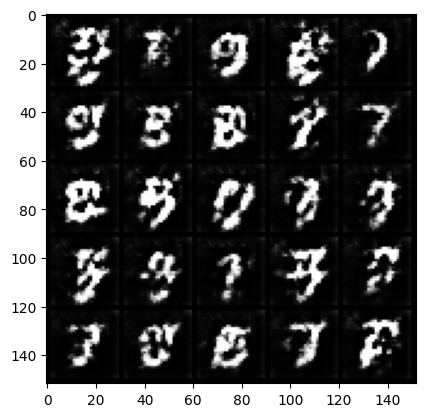

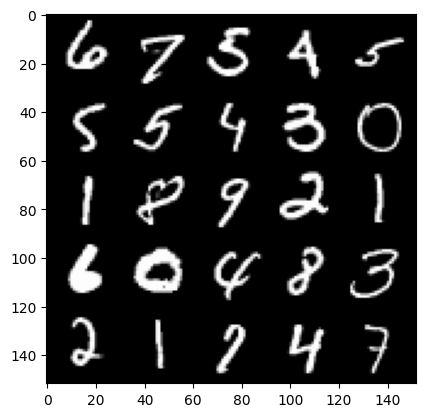

Step 10000: Generator loss: 0.7032517693161973, discriminator loss: 0.6891567142605798


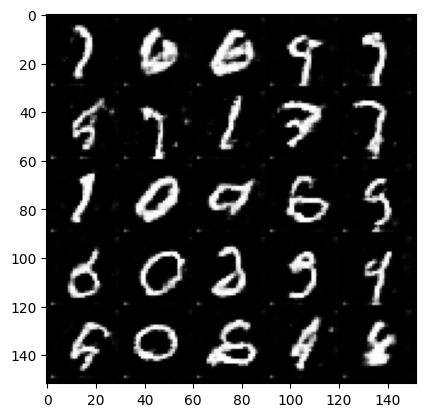

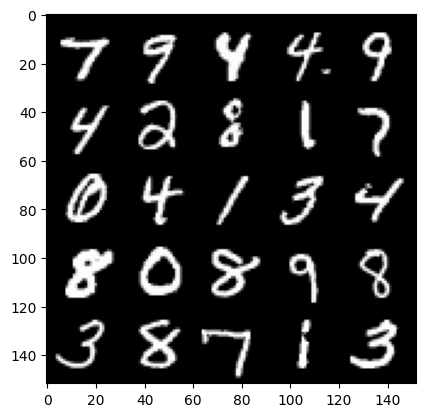

Step 15000: Generator loss: 0.6953411714315403, discriminator loss: 0.6936379548430429


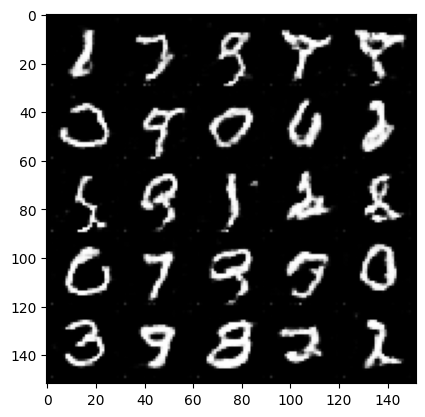

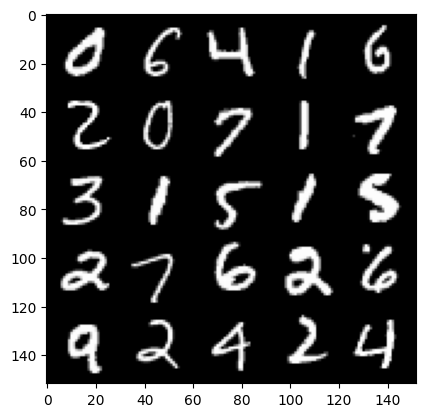

Step 20000: Generator loss: 0.6939975288867952, discriminator loss: 0.6937106892347354


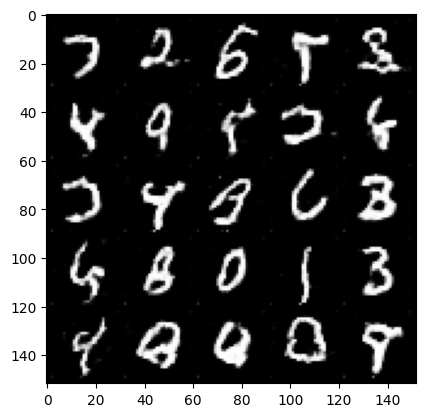

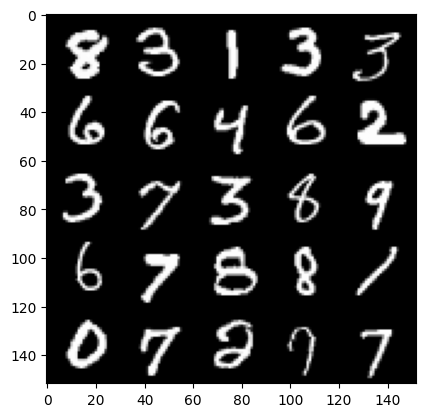

In [ ]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # for real, _ in tqdm(dataloader):
    for real, _ in dataloader:
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update Discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update Generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1